# [Bacterial Colony Growth](@id Bacteries)

In this example, we are going to create a bacterial model and grow a colony using it.

 - The implementation of the force interaction dynamics is the one presented by [Volfson et al. (2008)](https://www.pnas.org/doi/abs/10.1073/pnas.0706805105)
 - We use GPU accelerated dynamics

As described in other models, it is advised that the models are constructed by parts to avoid having to find bugs in a very complex system. Hence, we will split the model in two parts:

 - Forces model
 - Growth model

## Load the packages

In [1]:
using Base.Threads
println("Usando ", nthreads(), " threads 😎")

Usando 1 threads 😎


In [2]:
# import Pkg
# Pkg.activate("../")
# Pkg.instantiate()


In [3]:
# import Pkg; Pkg.add(["Revise", "GLMakie"])

In [4]:
# using Revise
# using CellBasedModels
# using CUDA
# using Distributions
# using GLMakie
# # using GeometryBasics
# import GLMakie: Point3f, Cylinder, Sphere, NoShading #Can be changes to Cairo or CLMakie

In [5]:
import Pkg

# Activa el entorno del proyecto
Pkg.activate("../../")

# Pkg.rm("GLMakie")

# Resuelve y asegura dependencias
Pkg.resolve()
Pkg.instantiate()

# Evita errores de versiones incompatibles forzando actualización
# Pkg.update(["CairoMakie", "Revise", "CUDA", "Distributions"])

# Carga los paquetes de forma ordenada
using Revise
using CellBasedModels
using CUDA
using Distributions
using CairoMakie
using JSON

# Importa funciones específicas después
import CairoMakie: Point3f, Cylinder, Sphere, NoShading

CairoMakie.activate!()


  Activating project at `c:\Users\u256063\Desktop\Projects\ABM_2\ABM_CBM`
  No Changes to `C:\Users\u256063\Desktop\Projects\ABM_2\ABM_CBM\Project.toml`
  No Changes to `C:\Users\u256063\Desktop\Projects\ABM_2\ABM_CBM\Manifest.toml`
┌ Warning: CUDA runtime library nvrtc64_112_0.dll was loaded from a system path. This may cause errors.
│ Ensure that you have not set the LD_LIBRARY_PATH environment variable, or that it does not contain paths to CUDA libraries.
└ @ CUDA C:\Users\u256063\.julia\packages\CUDA\jdJ7Z\src\initialization.jl:187


## Forces model

We already use the defined forces model that is implemented in CBqodels. This is an exact copy of the rod model that you can find already predefined in `Models/rods.jl`. You can check the `Models` section of the documentation for more details.


In [6]:
rod2D = ABM(2,
    agent = Dict(
            :theta=>Float64,
            :d=>Float64,
            :l=>Float64,
            :fx=>Float64,
            :fy=>Float64,
            :W=>Float64,
            :pressure=>Float64,
        ),    #Local Interaction Parameters

    model = Dict(
            :E=>Float64,
            :eta=>Float64,
        ),        #Global parameters

    agentODE = quote

        fx = 0
        fy = 0
        W = 0
        pressure = 0
        @loopOverNeighbors i2 begin

            #Use the model provided in the documentation
            Fijx, Fijy, Wij = CBMModels.repulsiveForces_rods(x,y,d,l,theta,
                                    x[i2],y[i2],d[i2],l[i2],theta[i2],eta, E)

            #Append the repulsive forces
            fx += Fijx
            fy += Fijy
            W += Wij

            Fijx, Fijy, Wij = CBMModels.repulsiveForces_rods(x,y,1,l,theta,
                        x[i2],y[i2],1,l[i2],theta[i2],eta, E)

            #Keep track of preassure in the media
            pressure += sqrt(Fijx^2+Fijy^2)
            
        end

        #Equations
        dt(x) =  fx 
        dt(y) =  fy 
        dt(theta) =  W
    end,

    neighborsAlg=CBMNeighbors.CellLinked(cellEdge=4),
    platform=CPU(),
    agentAlg = CBMIntegrators.Heun()
);


### Initialize a coqunity with two bacteries and check forces

In [7]:
com = Community(rod2D,
            N=30,
            dt=1.,
            simBox = [-10 10;-10 10.],
            );

#Natural units scales
m = 1.E-12 #ng
t = 1/(60*60) # h
d = 1.E-6 #um


com.E=100. *m/(t^2*d)*1.E-3 #kPa
com.eta=500 *m/(t*d) #Pa h


1.8000000000000003

In [8]:
for i in 1:com.N
    com.theta[i] = rand() * 2π
    com.x[i] = rand()*16-8
    com.y[i] = rand()*16-8
    com.l[i] = 3.0
    com.d[i] = 1.0

end

In [9]:
evolve!(com,steps=8000,saveEach=100,preallocateAgents=com.N)

In [10]:
function plotAgents2D!(ax, x, y, d, l, angle, p; colormap=:inferno, kargs...)
    for (xi, yi, li, di, ai, pi) in zip(x, y, l, d, angle, p)



            colorval = pi
            # colormap = :inferno
            meshscatter!(ax,
                [xi + li/2 * cos(ai)],
                [yi + li/2 * sin(ai)];
                marker = Sphere(Point3f(0, 0, 0), Float32(1)),
                markersize = [Point3f(di/2, di/2, di/2)],
                color = [colorval],
                colormap = colormap,
                kargs...
            )
            meshscatter!(ax,
                [xi - li/2 * cos(ai)],
                [yi - li/2 * sin(ai)];
                marker = Sphere(Point3f(0, 0, 0), Float32(1)),
                markersize = [Point3f(di/2, di/2, di/2)],
                color = [colorval],
                colormap = colormap,
                kargs...
            )
            meshscatter!(ax,
                [xi],
                [yi];
                marker = Cylinder(Point3f(-.5, 0, 0), Point3f(.5, 0, 0), Float32(1)),
                markersize = [Point3f(li, di/2, di/2)],
                rotation = [ai],
                color = [colorval],
                colormap = colormap,
                kargs...
            )

    end
    return
end


plotAgents2D! (generic function with 1 method)

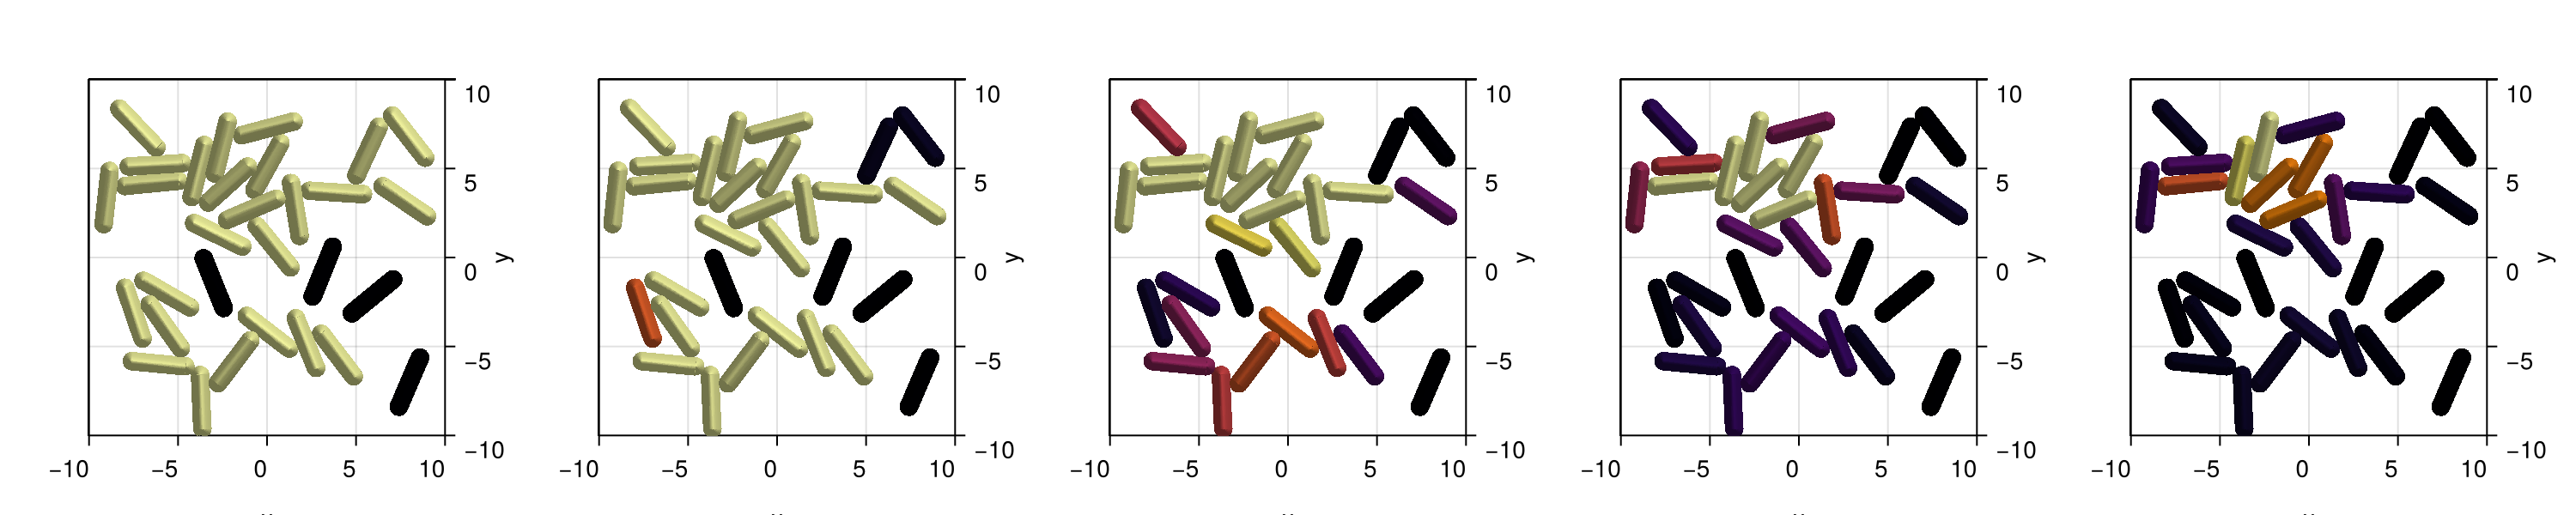

CairoMakie.Screen{IMAGE}


In [11]:
fig = Figure(size=(1500,300))

for (i,j) in enumerate([1:round(Int,length(com)/4):length(com);length(com)])
    ax = Axis3(fig[1,i],
                azimuth=3*π/2,
                elevation=π/2,
                zlabelvisible=false,
                zticklabelsvisible=false,
                zgridvisible=false,
                zspinesvisible=false
            )

    plotAgents2D!(
    ax,
    com[j][:x],
    com[j][:y],
    com[j][:d],
    com[j][:l],
    com[j][:theta],
    com[j][:pressure],
    colorrange = (0, maximum(com.pressure))
)

    xlims!(-10,10)
    ylims!(-10,10)
end

display(fig)

In [12]:

function log_community_state(parameters::OrderedDict, t::Int, path::String = "parameters_QS_cap.txt")
    # Convert keys to strings so JSON can serialize them
    string_keys = Dict(string(k) => v for (k, v) in parameters)
    # Build entry
    entry = Dict("t" => t, "parameters" => string_keys)
    # Save as a JSON line
    open(path, "a") do io
        println(io, JSON.json(entry))
    end
end


function load_parameters_log(path::String = "parameters_QS_cap.txt")
    log = Dict{Int, OrderedDict{Symbol, Any}}()
    for line in eachline(path)
        entry = JSON.parse(line)
        t = entry["t"]
        raw_params = entry["parameters"]
        params = OrderedDict(Symbol(k) => v for (k, v) in raw_params)
        log[t] = params
    end
    times = sort(collect(keys(log)))
    com_array = [log[t] for t in times]
    return com_array, times
end



load_parameters_log (generic function with 2 methods)

In [13]:
steps=1000
saveEach=100
N=100
loadToPlatform!(com,preallocateAgents=N)
open("parameters_QS_cap.txt", "w") do f
    # clear file at start
end


for step in 1:steps
    
    step!(com)

    if step % saveEach == 0
        bringFromPlatform!(com)
        if  N - com.N[1] < 2*com.N[1]
            N = 4*com.N[1]
        end
        println("Step ",step, " N: ", com.N[1])
        log_community_state(com.parameters, step)
        loadToPlatform!(com,preallocateAgents=N)
    end
end


Step 100 N: 30
Step 200 N: 30
Step 300 N: 30
Step 400 N: 30
Step 500 N: 30
Step 600 N: 30
Step 700 N: 30
Step 800 N: 30
Step 900 N: 30
Step 1000 N: 30


In [14]:
com_,times=load_parameters_log("parameters_QS_cap.txt")

(OrderedDict{Symbol, Any}[OrderedDict(:W => Any[3.795272411750074e-10, -3.799726874951415e-11, -2.901489372818433e-10, 2.803190481775416e-12, -3.37250805631622e-11, 0.0, -4.721897597793464e-12, -2.7635283888066345e-10, 0.0, -8.279307449521964e-10  …  4.971281194415498e-10, -1.4350162362188615e-11, 1.617665170125286e-10, 1.8310521442128998e-10, -1.525257628761595e-10, 1.1401353585075697e-9, 1.0716397897962732e-9, -9.6107904269135e-10, 1.5643312472843079e-12, 1.5376758950632365e-9], :fx => Any[-4.409341443430644e-9, 3.483907434480049e-10, 7.329472534326809e-10, -3.106609208959068e-11, -1.7599624107502915e-9, 0.0, -3.6202848669794373e-10, -4.535130733621627e-10, 0.0, 5.694535055159292e-9  …  -6.468037046526871e-9, 1.1977531202844895e-9, 4.061280026581171e-10, 1.6007603062909317e-9, 9.45723261222255e-10, -1.3303606831886792e-9, 3.2454491212569564e-9, -9.416643962551085e-10, 4.2715166362666883e-10, -2.175125432128259e-10], :x => Any[-6.5191555872939855, -5.623401426551339, 7.736444570030648

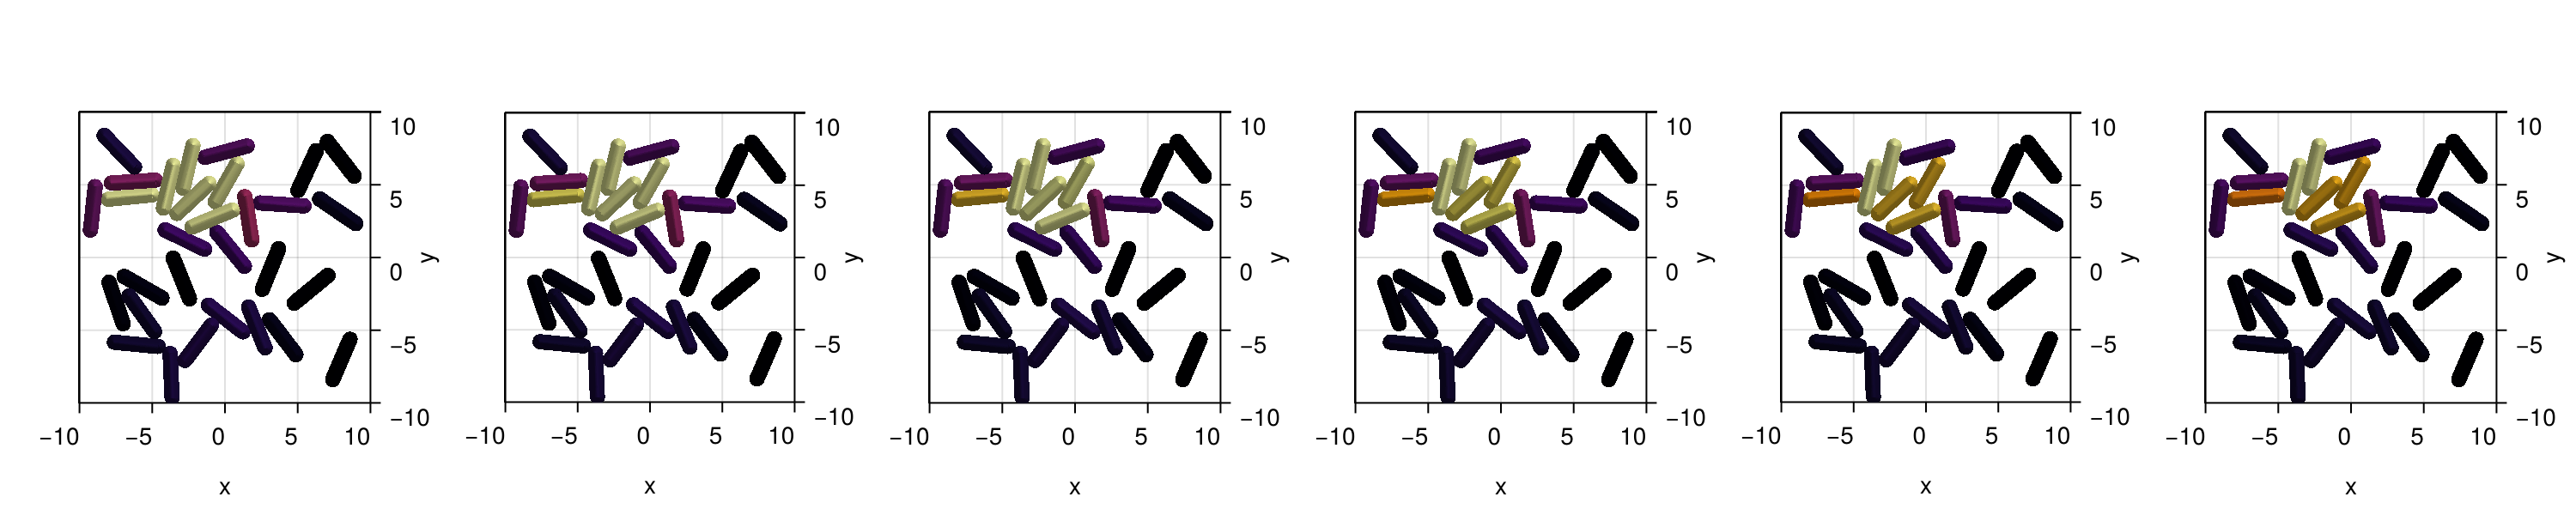

CairoMakie.Screen{IMAGE}


In [15]:
fig = Figure(size=(1500,300))

for (i,j) in enumerate([1:round(Int,length(com_)/4):length(com_);length(com_)])
    ax = Axis3(fig[1,i],
                azimuth=3*π/2,
                elevation=π/2,
                zlabelvisible=false,
                zticklabelsvisible=false,
                zgridvisible=false,
                zspinesvisible=false
            )

    plotAgents2D!(
    ax,
    com_[j][:x],
    com_[j][:y],
    com_[j][:d],
    com_[j][:l],
    com_[j][:theta],
    com_[j][:pressure],
    colorrange = (0, maximum((p[:pressure][1]) for p in com_))
)

    xlims!(-10,10)
    ylims!(-10,10)
end

display(fig)

## Growth model

We construct over the forces model to add bacterial growth and cell division rules.

In [ ]:
rods2dGrowth = ABM(2,
    baseModelInit = [rod2D],

    agent = Dict(
                :dg=> Float64, 
                :lTarget => Float64,
                :Ki => Float64, 
                :V => Float64, 
                :Vk => Float64, 
                :nk => Float64, 
            ),

    model = Dict(
                :growth=>Float64,
                :σlTarget=>Float64,
                :lMax=>Float64,
                :K_p=>Float64,
                :K_q=>Float64,
                :D_q => Float64,
                :delta_q => Float64,
                :r_q => Float64, 
                :r_H => Float64, 
                :F => Float64, 
                :gk => Float64, 
                :Vk0 => Float64, 
                :D_p => Float64, 
                :V0 => Float64, 
                :σ => Float64, 
                :alpha_ThT => Float64,
                :g_ThT => Float64,
                :V0ThT => Float64,
                :delta_ThT => Float64,
                :Dp => Float64,
                :Gi => Float64,
                :D_k => Float64,
                :VL0 => Float64,
                :dL => Float64,
                :gL => Float64,
                :Km => Float64,
                :alpha0 => Float64,
                :K_n => Float64,
                :b => Float64,

            ),
    
    medium = Dict(
        :q => Float64,        #Add a medium parameter
        :Ke => Float64,        #Add a medium parameter
        :ThT => Float64,        #Add a medium parameter
    ),

 
    agentODE = quote    
        VL=VL0+dL*(Ke-Km)/(1-exp(-(Ke-Km)/σ))
        dt(l) = l*growth/(1+K_p*pressure) #linear growth with growth dependent on the pressure over the cell
        dt(dg) = r_H*q^4/(K_q^4+q^4) #linear growth with growth dependent on the pressure over the cell
        dt(nk) = alpha0*q/(K_n+q)*(1-nk)-b*nk
        dt(Ki) = -F*gk*nk^4*(V-Vk)+Dp*Gi*Ke
        dt(Vk) = Vk0*log(Ke/Ki)
        dt(V) = -gk*nk^4*(V-Vk)-gL*(V-VL)

        fx = 0
        fy = 0
        W = 0
        pressure = 0
        @loopOverNeighbors i2 begin
            #Use the model provided in the documentation
            Fijx, Fijy, Wij = CBMModels.repulsiveForces_rods(x,y,dg,l,theta,
                                    x[i2],y[i2],dg[i2],l[i2],theta[i2],eta, E)

            #Append the repulsive forces
            fx += Fijx
            fy += Fijy
            W += Wij
            
            pressure += sqrt(Fijx^2+Fijy^2)

            
        end
        #Equations
        dt(x) =  fx 
        dt(y) =  fy 
        dt(theta) =  W
    end,

    agentRule = quote #Bound cells
        #Add division
        if l > lTarget
            ww = CBMDistributions.uniform(-.1,.1)/10000 #To add some random torque at division time
            # ww = 0 #To add some random torque at division time
            #Add a new cell
            @addAgent(
                    x=(l+d)/4*cos(theta)+x,
                    y=(l+d)/4*sin(theta)+y,
                    l=(l-d)/2,
                    W=ww,
                    lTarget = CBMDistributions.uniform(lMax-σlTarget,lMax+σlTarget),
                    dg=-l/pi+sqrt((l/pi)^2+dg^2/2+2*l/pi),)
            #Add a second cell
            @addAgent(
                    x=-(l+d)/4*cos(theta)+x,
                    y=-(l+d)/4*sin(theta)+y,
                    l=(l-d)/2,
                    lTarget = CBMDistributions.uniform(lMax-σlTarget,lMax+σlTarget), #New target length at which the bactery should divide
                    W=ww,
                    dg=-l/pi+sqrt((l/pi)^2+dg^2/2+2*l/pi))
            #Remove the old cell
            @removeAgent()
        end
        # Probability of releasing q with a saturating function
        pq = pressure/(K_p+pressure)
        if CBMDistributions.uniform(0, 1) < pq
            q += r_q
        end

        # # Probability of releasing PGA with a saturating function
        # pg = q/(q+K_q)
        # if CBMDistributions.uniform(0, 1) < pg
        #     H += r_H
        # end
    end,

    #Medium dynamics with dirichlet conditions and a wall that is as oscillating source of material
    mediumODE=quote 
        if @mediumInside()
            dt(q) = D_q*(@∂2(1,q)+@∂2(2,q)) - delta_q*q 
            # dt(Ke) = F*gk*nk^4*(V-Vk)-Dp*Gi*Ke+D_k*(@∂2(1,Ke)+@∂2(2,Ke))
            # dt(ThT) = alpha_ThT/(1+exp(g_ThT*(V-V0ThT))) - delta_ThT*ThT
        end

    end,

    neighborsAlg=CBMNeighbors.CellLinked(cellEdge=4),
    platform=CPU(),
    agentAlg=CBMIntegrators.Heun()
);

## Grow colony from one cell

In [64]:
com = Community(rods2dGrowth,
            N=1,
            dt=1.,
            simBox = [-100 100;-100 100.],
            NMedium=[100,100],
            );

#Natural units scales
m = 1.E-12 #ng
t = 1/(60*60) # h
d = 1.E-6 #um


com.E=20. *m/(t^2*d)*1.E-3 #kPa
com.eta=500 *m/(t*d) #Pa h
com.D_q = 1.E-5 /t #um^2/h
com.delta_q = 1.E-10 
com.r_q = 1
com.dg=1.

com.growth = 0.5 * t
com.lMax = 4.     
com.σlTarget = 1. 
com.K_p = 10
com.K_q = 100
 
com.d = 1.        
com.l = 3.99      
com.lTarget = 4.  
com.r_H = 100.  

com.F=0.05
com.gk =70
com.V0 = -150
com.Ki=300.
com.Ke=8.
com.σ=0.1
com.Vk=100.
com.alpha_ThT = 20
com.g_ThT = 0.3
com.V0ThT = 100.
com.delta_ThT = 10
com.Dp = 0.12
com.Gi = 20
# com.D_k = 0.01
com.D_k = 1E-7
com.VL0 = -156
com.dL=4.
com.gL=18.
com.Km=8.
com.alpha0=91.
com.K_n=1.
com.b=34.

com.x = 0
com.y = 0
com.theta = 0;

In [65]:
steps=2000
saveEach=1000
# steps=100000
# saveEach=10000
N=100 

loadToPlatform!(com,preallocateAgents=N)
open("parameters_QS_cap.txt", "w") do f
    # clear file at start
end

for step in 1:steps
    
    step!(com)

    if step % saveEach == 0
        bringFromPlatform!(com)
        if N - com.N[1] <= 0
                println("Step ",step, " N: ", com.N[1], " preallocateAgents: ", N)
                @warn "More agents than preallocateAgents, stopping simulation."
                break
        elseif   N - com.N[1]  < 4*com.N[1]
                N = 15*com.N[1]
        end 
        println("Step ",step, " N: ", com.N[1])
        log_community_state(com.parameters, step)
        loadToPlatform!(com,preallocateAgents=N)
    end
end
bringFromPlatform!(com)


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\u256063\.julia\packages\SciMLBase\OK4PC\src\integrator_interface.jl:611


Step 1000 N: 2


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\u256063\.julia\packages\SciMLBase\OK4PC\src\integrator_interface.jl:611


Step 2000 N: 2


In [19]:
steps=70000
prev_steps=50000
saveEach=1000
# steps=100000
# saveEach=10000
# N=100 

loadToPlatform!(com,preallocateAgents=N)
# open("parameters_QS_cap.txt", "w") do f
#     # clear file at start
# end

for step in 1+prev_steps:steps
    
    step!(com)

    if step % saveEach == 0
        bringFromPlatform!(com)
        if N - com.N[1] <= 0
                println("Step ",step, " N: ", com.N[1], " preallocateAgents: ", N)
                @warn "More agents than preallocateAgents, stopping simulation."
                break
        elseif   N - com.N[1]  < 4*com.N[1]
                N = 15*com.N[1]
        end 
        println("Step ",step, " N: ", com.N[1])
        log_community_state(com.parameters, step)
        loadToPlatform!(com,preallocateAgents=N)
    end
end
bringFromPlatform!(com)


Step 51000 N: 209
Step 52000 N: 235
Step 53000 N: 253
Step 54000 N: 254
Step 55000 N: 265
Step 56000 N: 281
Step 57000 N: 301
Step 58000 N: 334
Step 59000 N: 373
Step 60000 N: 423
Step 61000 N: 476
Step 62000 N: 506
Step 63000 N: 524
Step 64000 N: 543
Step 65000 N: 580
Step 66000 N: 637
Step 67000 N: 716
Step 68000 N: 804
Step 69000 N: 887
Step 70000 N: 945


In [20]:
com_load,times=load_parameters_log("parameters_QS_cap.txt")


(OrderedDict{Symbol, Any}[OrderedDict(:W => Any[-8.621967291348209e-10, -8.621967291348209e-10], :fx => Any[-0.00011676249085290218, 0.00011676249085290218], :delta_q => Any[1.0e-10], :x => Any[-1.3423391500502002, 1.3423391500502002], :K_p => Any[10.0], :σlTarget => Any[1.0], :theta => Any[-8.565703134804726e-6, -8.565703134804726e-6], :r_H => Any[100.0], :q => Any[Any[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Any[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Any[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Any[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Any[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Any[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

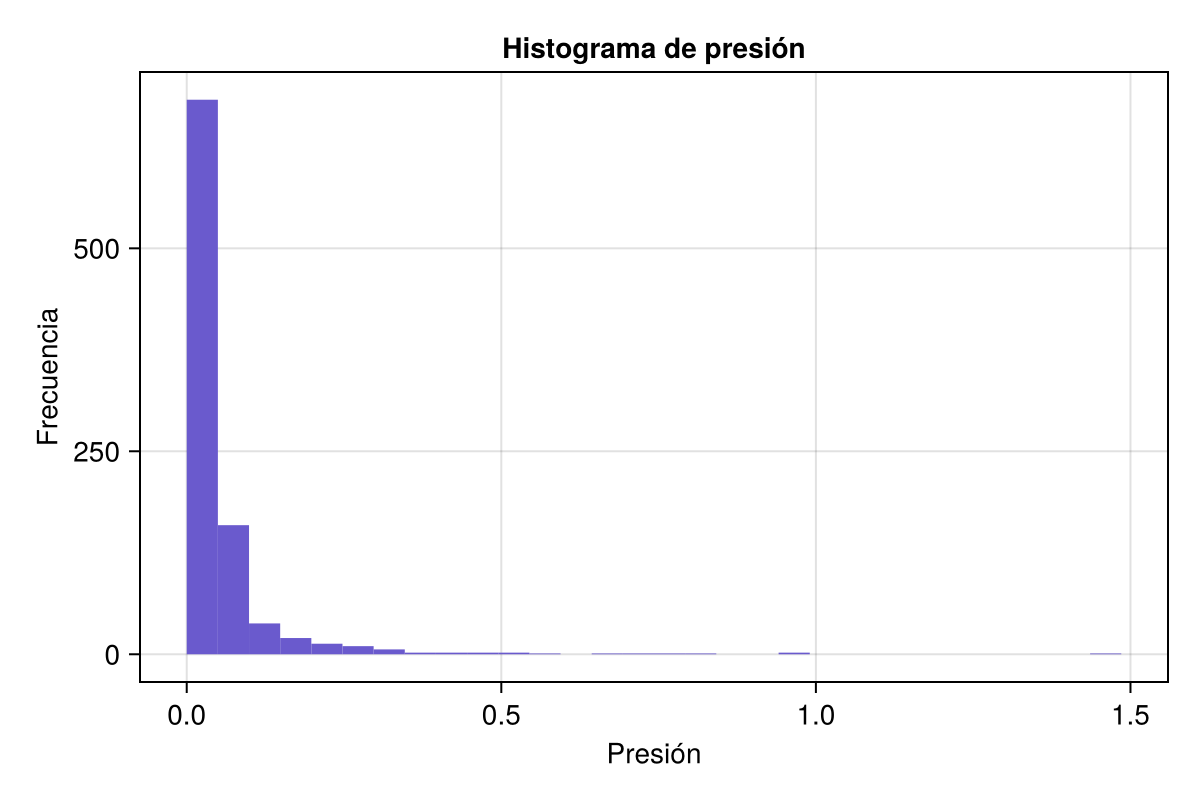

In [21]:
# Elegimos un frame, por ejemplo el último
p = com_load[end][:pressure]

# Creamos la figura y el eje
fig = Figure(size = (600, 400))
ax = Axis(fig[1, 1]; xlabel = "Presión", ylabel = "Frecuencia", title = "Histograma de presión")

# Dibujamos el histograma
hist!(ax, p; bins = 30, color = :slateblue)

fig  # Esto muestra la figura en una ventana interactiva

In [22]:
maximum(maximum(p -> maximum(p[:q]), com_load))

7.264368399956995

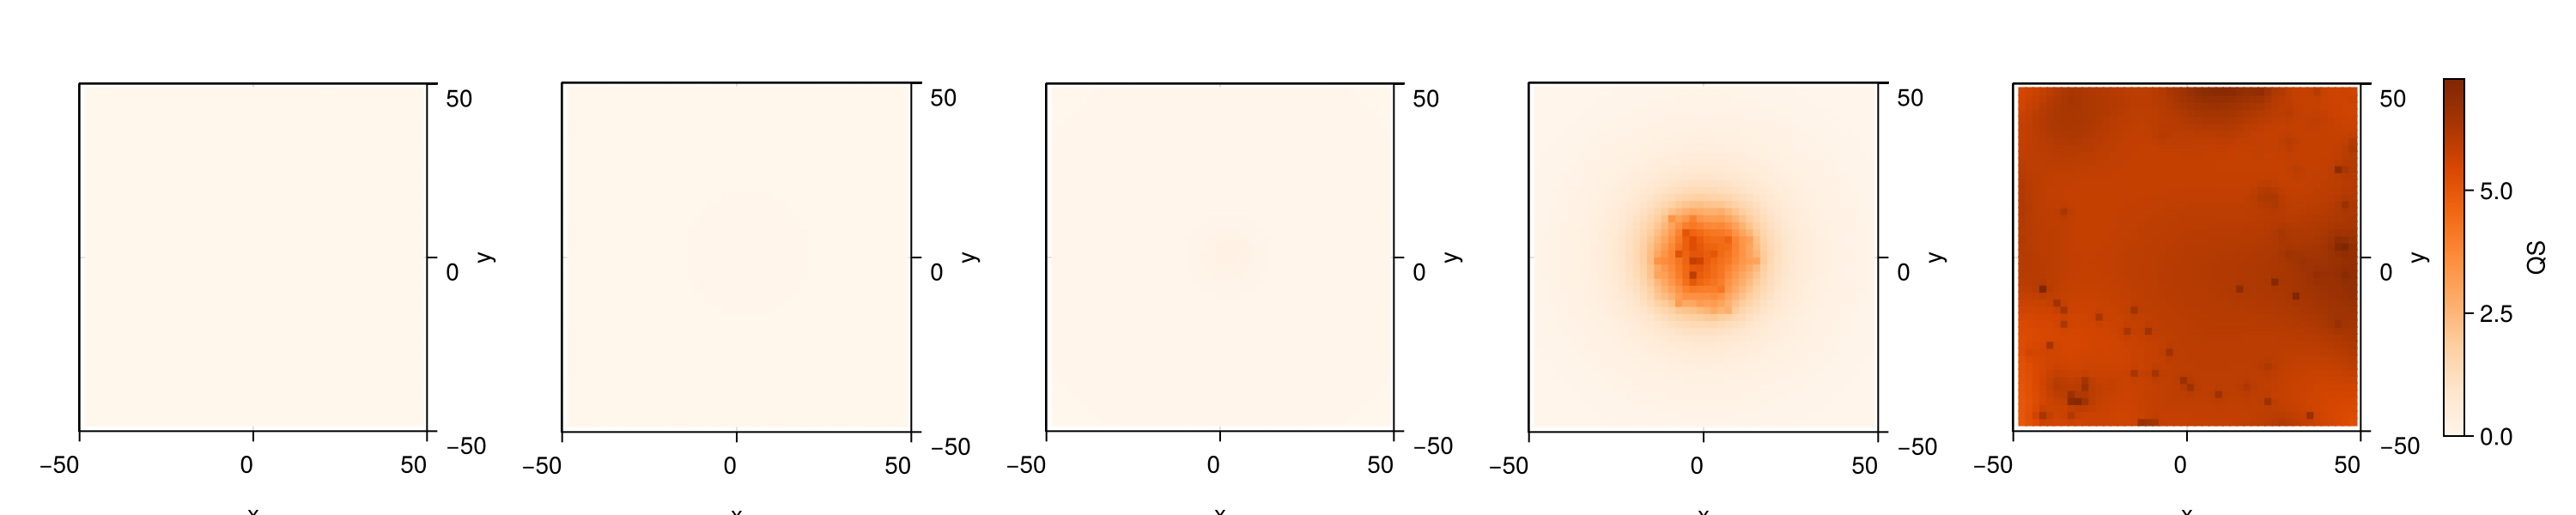

CairoMakie.Screen{IMAGE}


In [23]:
# Colormap común y colorrange fijo
colormap = :Oranges
colorrange = (0.0,  maximum(maximum(p -> maximum(p[:q]), com_load)))
# colorrange = (0.0,  0.01)

fig = Figure(size=(1500,300))

js = [1:round(Int, length(com_load)/4):length(com_load); length(com_load)]

for (i,j) in enumerate(js)
    ax = Axis3(fig[1,i],
                azimuth=3*π/2,
                elevation=π/2,
                zlabelvisible=false,
                zticklabelsvisible=false,
                zgridvisible=false,
                zspinesvisible=false
            )
    m = heatmap!(ax,
                range(com.simBox[1,1],com.simBox[1,2],length=size(com.q)[1]),
                range(com.simBox[2,1],com.simBox[2,2],length=size(com.q)[1]),
                Float64.(hcat(com_load[j][:q]...)),
                colormap = colormap,
                colorrange = colorrange
            )
    

    # plotAgents2D!(
    # ax,
    # com_load[j][:x],
    # com_load[j][:y],
    # com_load[j][:dg],
    # com_load[j][:l],
    # com_load[j][:theta],
    # com_load[j][:dg],
    # colormap=:Blues,
    # colorrange = colorrange
    # )

    xlims!(-50,50)
    ylims!(-50,50)
end

# Añadir colorbar común al final
Colorbar(fig[1, length(js) + 1],
    colormap = colormap,
    colorrange = colorrange,
    label = "QS"
)

display(fig)

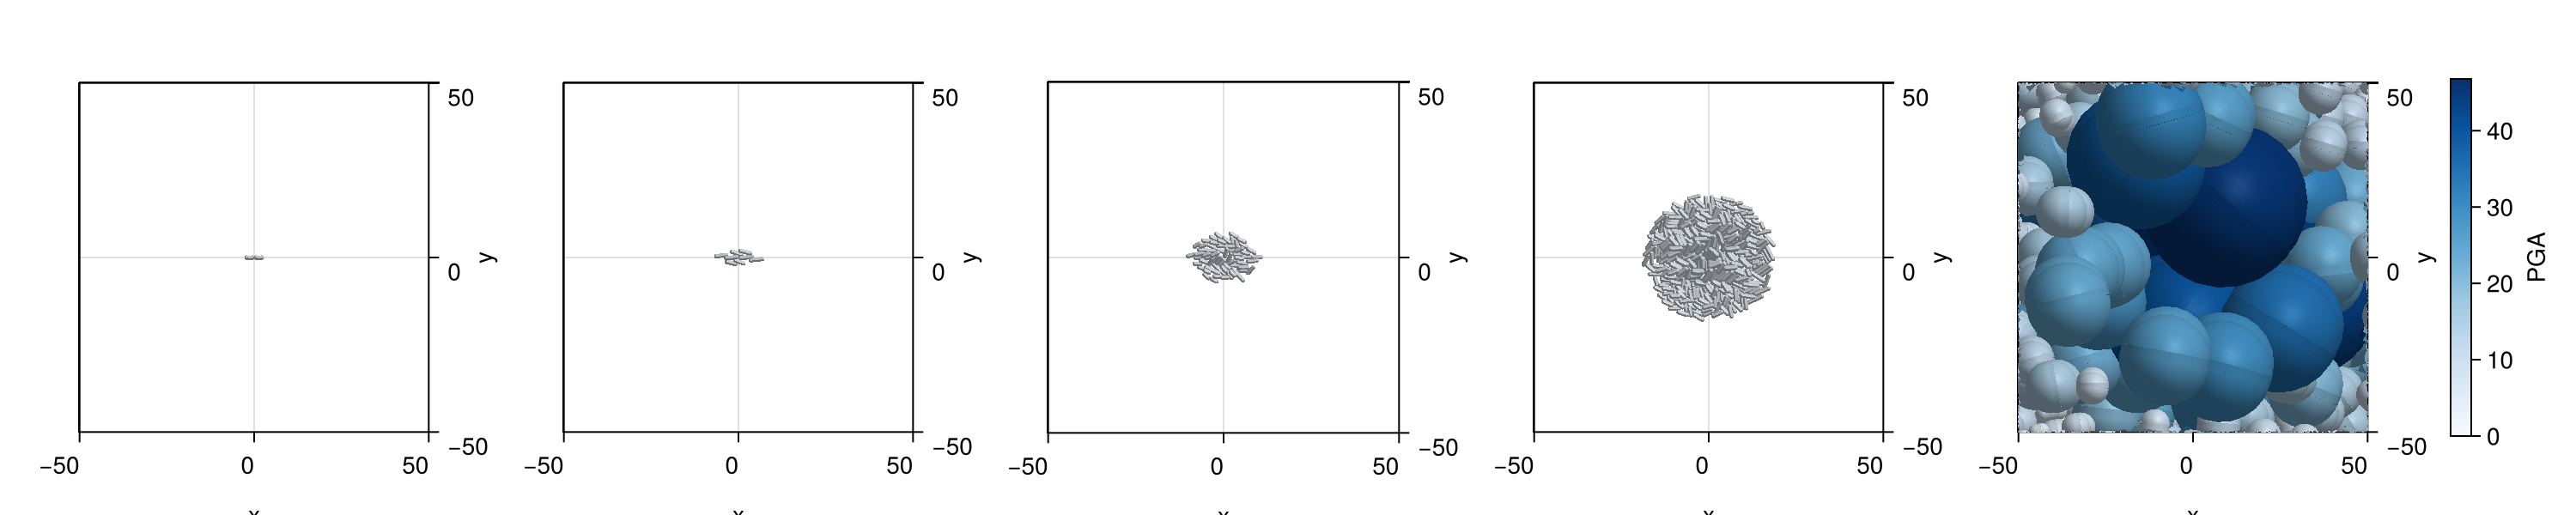

CairoMakie.Screen{IMAGE}


In [24]:
# Colormap común y colorrange fijo
colormap = :Blues
colorrange = (0.0,  maximum(maximum(p -> maximum(p[:dg]), com_load)))



fig = Figure(size=(1500,300))

js = [1:round(Int, length(com_load)/4):length(com_load); length(com_load)]

for (i,j) in enumerate(js)
    ax = Axis3(fig[1,i],
                azimuth=3*π/2,
                elevation=π/2,
                zlabelvisible=false,
                zticklabelsvisible=false,
                zgridvisible=false,
                zspinesvisible=false
            )
    # m = heatmap!(ax,
    #             range(com.simBox[1,1],com.simBox[1,2],length=size(com.q)[1]),
    #             range(com.simBox[2,1],com.simBox[2,2],length=size(com.q)[1]),
    #             Float64.(hcat(com_load[j][:q]...)),
    #             colormap = colormap,
    #             colorrange = colorrange
    #         )
    

    plotAgents2D!(
    ax,
    com_load[j][:x],
    com_load[j][:y],
    com_load[j][:dg],
    com_load[j][:l],
    com_load[j][:theta],
    com_load[j][:dg],
    colormap=:Blues,
    colorrange = colorrange
    )

    xlims!(-50,50)
    ylims!(-50,50)
end

# Añadir colorbar común al final
Colorbar(fig[1, length(js) + 1],
    colormap = colormap,
    colorrange = colorrange,
    label = "PGA"
)

display(fig)

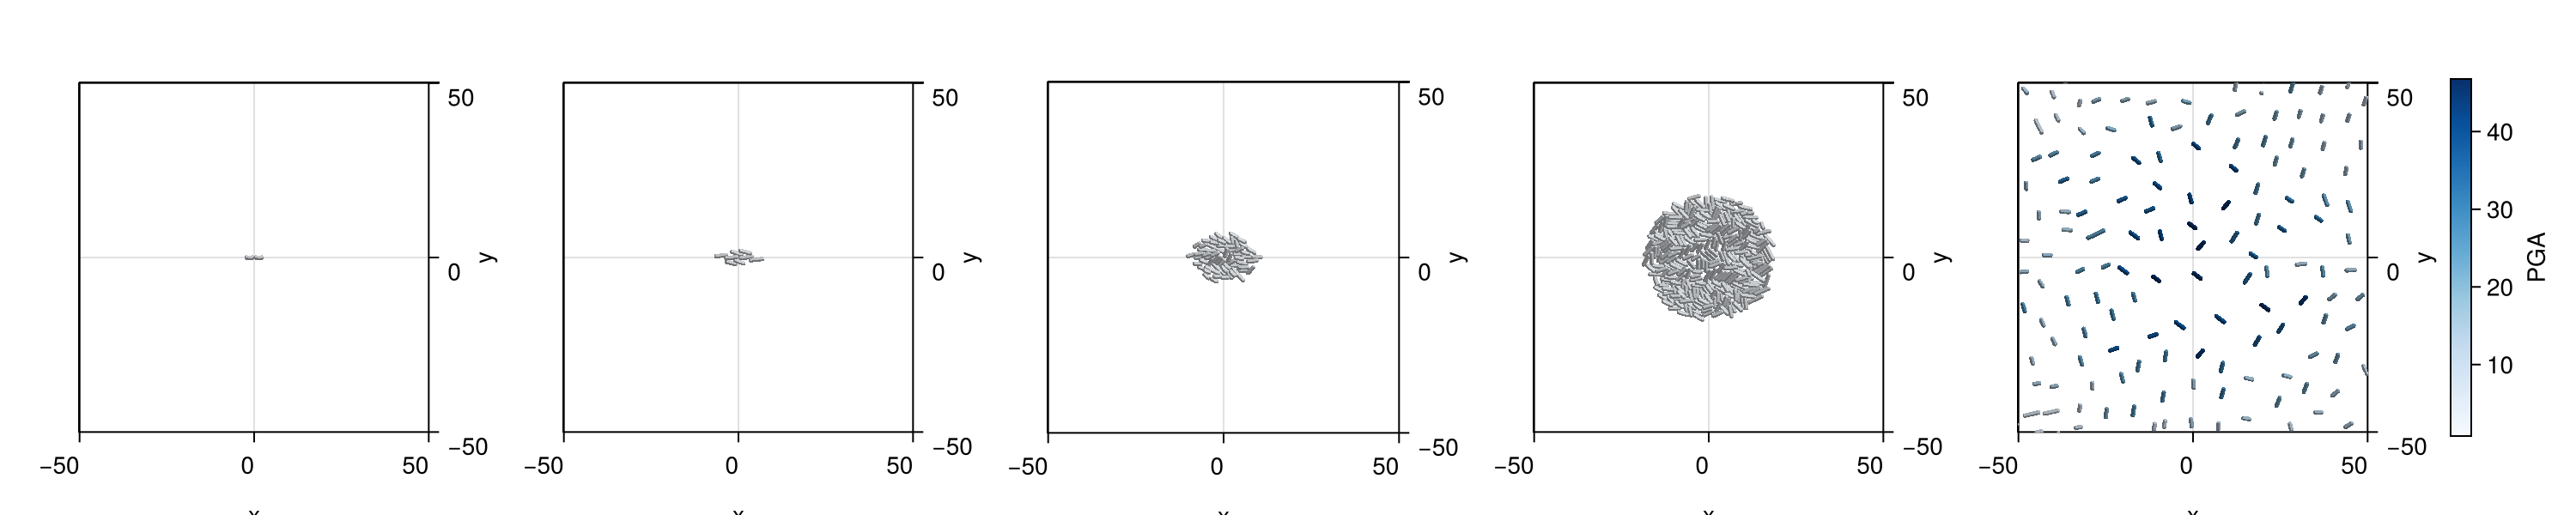

CairoMakie.Screen{IMAGE}


In [25]:
# Colormap común y colorrange fijo
colormap = :Blues
colorrange = (0.8,  maximum(maximum(p -> maximum(p[:dg]), com_load)))



fig = Figure(size=(1500,300))

js = [1:round(Int, length(com_load)/4):length(com_load); length(com_load)]

for (i,j) in enumerate(js)
    ax = Axis3(fig[1,i],
                azimuth=3*π/2,
                elevation=π/2,
                zlabelvisible=false,
                zticklabelsvisible=false,
                zgridvisible=false,
                zspinesvisible=false
            )
    # m = heatmap!(ax,
    #             range(com.simBox[1,1],com.simBox[1,2],length=size(com.q)[1]),
    #             range(com.simBox[2,1],com.simBox[2,2],length=size(com.q)[1]),
    #             Float64.(hcat(com_load[j][:q]...)),
    #             colormap = colormap,
    #             colorrange = colorrange
    #         )
    

    plotAgents2D!(
    ax,
    com_load[j][:x],
    com_load[j][:y],
    com_load[j][:d],
    com_load[j][:l],
    com_load[j][:theta],
    com_load[j][:dg],
    colormap=:Blues,
    colorrange = colorrange,
    )

    xlims!(-50,50)
    ylims!(-50,50)
end

# Añadir colorbar común al final
Colorbar(fig[1, length(js) + 1],
    colormap = colormap,
    colorrange = colorrange,
    label = "PGA"
)

display(fig)

In [26]:

# Configuración general
colormap = :Oranges
colorrange = (0,  maximum(maximum(p -> maximum(p[:q]), com_load)))


# Crear figura y ejes
fig = Figure(size = (800, 600))
grid = fig[1, 1] = GridLayout()
ax = Axis(grid[1, 1]; aspect = DataAspect())
Colorbar(grid[1, 2], colormap=colormap, colorrange=colorrange, label="QS")  # una vez



n_repeats = 10  # Número de veces que repetimos cada frame
framerate = 10  # 10 fps → cada frame se mantiene 1 segundo

Makie.record(fig, "bacterias_cap_QS.mp4", 1:length(com_load) * n_repeats; framerate = framerate) do i
    j = ceil(Int, i / n_repeats)  # Frame real 
    Makie.empty!(ax)
    # Preparar heatmap observable para actualizar luego
    x = range(com.simBox[1,1], com.simBox[1,2], length=size(com.q)[1])
    y = range(com.simBox[2,1], com.simBox[2,2], length=size(com.q)[2])
    z = copy(hcat(com_load[j][:q]...))  # inicializa con primer frame

    hm = heatmap!(ax, x, y, z; colormap=colormap, colorrange=colorrange)

    # plotMixedAgents2D!(
    #     ax,
    #     com_load[j][:x],
    #     com_load[j][:y],
    #     com_load[j][:d],
    #     com_load[j][:l],
    #     com_load[j][:theta],
    #     com_load[j][:type],
    #     com_load[j][:pressure],
    #     colorrange = (0, 0.03)
    # )


    xlims!(ax, -50, 50)
    ylims!(ax, -50, 50)
end


"bacterias_cap_QS.mp4"

In [27]:

# Configuración general
colormap = :Oranges
colorrange = (0,  maximum(maximum(p -> maximum(p[:q]), com_load)))


# Crear figura y ejes
fig = Figure(size = (800, 600))
grid = fig[1, 1] = GridLayout()
ax = Axis(grid[1, 1]; aspect = DataAspect())
Colorbar(grid[1, 2], colormap=colormap, colorrange=colorrange, label="QS")  # una vez



n_repeats = 10  # Número de veces que repetimos cada frame
framerate = 10  # 10 fps → cada frame se mantiene 1 segundo

Makie.record(fig, "bacterias_cap_QS_zoom.mp4", 1:length(com_load) * n_repeats; framerate = framerate) do i
    j = ceil(Int, i / n_repeats)  # Frame real 
    Makie.empty!(ax)
    # Preparar heatmap observable para actualizar luego
    x = range(com.simBox[1,1], com.simBox[1,2], length=size(com.q)[1])
    y = range(com.simBox[2,1], com.simBox[2,2], length=size(com.q)[2])
    z = copy(hcat(com_load[j][:q]...))  # inicializa con primer frame

    hm = heatmap!(ax, x, y, z; colormap=colormap, colorrange=colorrange)

    # plotMixedAgents2D!(
    #     ax,
    #     com_load[j][:x],
    #     com_load[j][:y],
    #     com_load[j][:d],
    #     com_load[j][:l],
    #     com_load[j][:theta],
    #     com_load[j][:type],
    #     com_load[j][:pressure],
    #     colorrange = (0, 0.03)
    # )


    xlims!(ax, -100, 100)
    ylims!(ax, -100, 100)
end


"bacterias_cap_QS_zoom.mp4"

In [28]:

# Configuración general
colormap = Reverse(:Blues)
colorrange = (0,  maximum(maximum(p -> maximum(p[:dg]), com_load)))


# Crear figura y ejes
fig = Figure(size = (800, 600))
grid = fig[1, 1] = GridLayout()
ax = Axis(grid[1, 1]; aspect = DataAspect())
Colorbar(grid[1, 2], colormap=colormap, colorrange=colorrange, label="PGA")  # una vez

n_repeats = 10  # Número de veces que repetimos cada frame
framerate = 10  # 10 fps → cada frame se mantiene 1 segundo

Makie.record(fig, "bacterias_cap.mp4", 1:length(com_load) * n_repeats; framerate = framerate) do i
    j = ceil(Int, i / n_repeats)  # Frame real   
    Makie.empty!(ax)
    # Preparar heatmap observable para actualizar luego
    # x = range(com.simBox[1,1], com.simBox[1,2], length=size(com.H)[1])
    # y = range(com.simBox[2,1], com.simBox[2,2], length=size(com.H)[2])
    # z = copy(hcat(com_load[j][:H]...))  # inicializa con primer frame

    # hm = heatmap!(ax, x, y, z; colormap=colormap, colorrange=colorrange)

    plotAgents2D!(
        ax,
        com_load[j][:x],
        com_load[j][:y],
        com_load[j][:d],
        com_load[j][:l],
        com_load[j][:theta],
        com_load[j][:dg],
        colorrange = colorrange,
        colormap= colormap,
    )


    xlims!(ax, -50, 50)
    ylims!(ax, -50, 50)
end


"bacterias_cap.mp4"

In [29]:

# Configuración general
colormap = Reverse(:Blues)
colorrange = (0,  maximum(maximum(p -> maximum(p[:dg]), com_load)))


# Crear figura y ejes
fig = Figure(size = (800, 600))
grid = fig[1, 1] = GridLayout()
ax = Axis(grid[1, 1]; aspect = DataAspect())
Colorbar(grid[1, 2], colormap=colormap, colorrange=colorrange, label="PGA")  # una vez


n_repeats = 10  # Número de veces que repetimos cada frame
framerate = 10  # 10 fps → cada frame se mantiene 1 segundo

Makie.record(fig, "bacterias_cap_zoom.mp4", 1:length(com_load) * n_repeats; framerate = framerate) do i
    j = ceil(Int, i / n_repeats)  # Frame real  
    Makie.empty!(ax)
    # Preparar heatmap observable para actualizar luego
    # x = range(com.simBox[1,1], com.simBox[1,2], length=size(com.H)[1])
    # y = range(com.simBox[2,1], com.simBox[2,2], length=size(com.H)[2])
    # z = copy(hcat(com_load[j][:H]...))  # inicializa con primer frame

    # hm = heatmap!(ax, x, y, z; colormap=colormap, colorrange=colorrange)

    plotAgents2D!(
        ax,
        com_load[j][:x],
        com_load[j][:y],
        com_load[j][:d],
        com_load[j][:l],
        com_load[j][:theta],
        com_load[j][:dg],
        colorrange = colorrange,
        colormap= colormap,
    )


    xlims!(ax, -100, 100)
    ylims!(ax, -100, 100)
end


"bacterias_cap_zoom.mp4"

In [30]:

# Configuración general
colormap = Reverse(:Blues)
colorrange = (0,  maximum(maximum(p -> maximum(p[:dg]), com_load)))


# Crear figura y ejes
fig = Figure(size = (800, 600))
grid = fig[1, 1] = GridLayout()
ax = Axis(grid[1, 1]; aspect = DataAspect())
Colorbar(grid[1, 2], colormap=colormap, colorrange=colorrange, label="PGA")  # una vez


n_repeats = 10  # Número de veces que repetimos cada frame
framerate = 10  # 10 fps → cada frame se mantiene 1 segundo

Makie.record(fig, "bacterias_cap_pga.mp4", 1:length(com_load) * n_repeats; framerate = framerate) do i
    j = ceil(Int, i / n_repeats)  # Frame real 
    Makie.empty!(ax)
    # Preparar heatmap observable para actualizar luego
    # x = range(com.simBox[1,1], com.simBox[1,2], length=size(com.H)[1])
    # y = range(com.simBox[2,1], com.simBox[2,2], length=size(com.H)[2])
    # z = copy(hcat(com_load[j][:H]...))  # inicializa con primer frame

    # hm = heatmap!(ax, x, y, z; colormap=colormap, colorrange=colorrange)

    plotAgents2D!(
        ax,
        com_load[j][:x],
        com_load[j][:y],
        com_load[j][:dg],
        com_load[j][:l],
        com_load[j][:theta],
        com_load[j][:dg],
        colorrange = colorrange,
        colormap = colormap
    )


    xlims!(ax, -50, 50)
    ylims!(ax, -50, 50)
end


"bacterias_cap_pga.mp4"

In [32]:
# Configuración general
colormap = Reverse(:Blues)
colorrange = (0,  maximum(maximum(p -> maximum(p[:dg]), com_load)))


# Crear figura y ejes
fig = Figure(size = (800, 600))
grid = fig[1, 1] = GridLayout()
ax = Axis(grid[1, 1]; aspect = DataAspect())
Colorbar(grid[1, 2], colormap=colormap, colorrange=colorrange, label="PGA")  # una vez



n_repeats = 10  # Número de veces que repetimos cada frame
framerate = 10  # 10 fps → cada frame se mantiene 1 segundo

Makie.record(fig, "bacterias_cap_pga_zoom.mp4", 1:length(com_load) * n_repeats; framerate = framerate) do i
    j = ceil(Int, i / n_repeats)  # Frame real

    Makie.empty!(ax)

    plotAgents2D!(
        ax,
        com_load[j][:x],
        com_load[j][:y],
        com_load[j][:dg],
        com_load[j][:l],
        com_load[j][:theta],
        com_load[j][:dg],
        colormap = colormap,
        colorrange = colorrange
    )

    xlims!(ax, -100, 100)
    ylims!(ax, -100, 100)
end


"bacterias_cap_pga_zoom.mp4"

In [33]:
# Configuración general
colormap_p = Reverse(:Blues)
colorrange_p = (0,  maximum(maximum(p -> maximum(p[:dg]), com_load)))

# Configuración general
colormap_q = :Oranges
colorrange_q = (0,  maximum(maximum(p -> maximum(p[:q]), com_load)))

# Crear figura y ejes
fig = Figure(size = (800, 600))
grid = fig[1, 1] = GridLayout()
ax = Axis(grid[1, 1]; aspect = DataAspect())
Colorbar(grid[1, 2], colormap=colormap_p, colorrange=colorrange_p, label="PGA")  # una vez
Colorbar(grid[1, 3], colormap=colormap_q, colorrange=colorrange_q, label="QS")  # una vez



n_repeats = 10  # Número de veces que repetimos cada frame
framerate = 10  # 10 fps → cada frame se mantiene 1 segundo

Makie.record(fig, "bacterias_cap_all_pga_zoom.mp4", 1:length(com_load) * n_repeats; framerate = framerate) do i
    j = ceil(Int, i / n_repeats)  # Frame real

    Makie.empty!(ax)

    x = range(com.simBox[1,1], com.simBox[1,2], length=size(com.q)[1])
    y = range(com.simBox[2,1], com.simBox[2,2], length=size(com.q)[2])
    z = copy(hcat(com_load[j][:q]...))  # inicializa con primer frame

    hm = heatmap!(ax, x, y, z; colormap=colormap_q, colorrange=colorrange_q)

    plotAgents2D!(
        ax,
        com_load[j][:x],
        com_load[j][:y],
        com_load[j][:dg],
        com_load[j][:l],
        com_load[j][:theta],
        com_load[j][:dg],
        colormap = colormap_p,
        colorrange = colorrange_p
    )

    xlims!(ax, -100, 100)
    ylims!(ax, -100, 100)
end


"bacterias_cap_all_pga_zoom.mp4"

In [34]:
# Configuración general
colormap_p = Reverse(:Blues)
colorrange_p = (0,  maximum(maximum(p -> maximum(p[:dg]), com_load)))

# Configuración general
colormap_q = :Oranges
colorrange_q = (0,  maximum(maximum(p -> maximum(p[:q]), com_load)))

# Crear figura y ejes
fig = Figure(size = (800, 600))
grid = fig[1, 1] = GridLayout()
ax = Axis(grid[1, 1]; aspect = DataAspect())
Colorbar(grid[1, 2], colormap=colormap_p, colorrange=colorrange_p, label="PGA")  # una vez
Colorbar(grid[1, 3], colormap=colormap_q, colorrange=colorrange_q, label="QS")  # una vez



n_repeats = 10  # Número de veces que repetimos cada frame
framerate = 10  # 10 fps → cada frame se mantiene 1 segundo

Makie.record(fig, "bacterias_cap_all_zoom.mp4", 1:length(com_load) * n_repeats; framerate = framerate) do i
    j = ceil(Int, i / n_repeats)  # Frame real

    Makie.empty!(ax)

    x = range(com.simBox[1,1], com.simBox[1,2], length=size(com.q)[1])
    y = range(com.simBox[2,1], com.simBox[2,2], length=size(com.q)[2])
    z = copy(hcat(com_load[j][:q]...))  # inicializa con primer frame

    hm = heatmap!(ax, x, y, z; colormap=colormap_q, colorrange=colorrange_q)

    plotAgents2D!(
        ax,
        com_load[j][:x],
        com_load[j][:y],
        com_load[j][:d],
        com_load[j][:l],
        com_load[j][:theta],
        com_load[j][:dg],
        colormap = colormap_p,
        colorrange = colorrange_p
    )

    xlims!(ax, -100, 100)
    ylims!(ax, -100, 100)
end


"bacterias_cap_all_zoom.mp4"

In [45]:
# Configuración general
colormap_p = Reverse(:Blues)
colorrange_p = (0,  maximum(maximum(p -> maximum(p[:dg]), com_load)))

# Configuración general
colormap_q = :Oranges
colorrange_q = (0,  maximum(maximum(p -> maximum(p[:q]), com_load)))

# Crear figura y ejes
fig = Figure(size = (1200, 600))
grid = fig[1, 1] = GridLayout()
# ax1 = Axis(grid[1, 1]; aspect = DataAspect())
# ax2 = Axis(grid[1, 2]; aspect = DataAspect())
# ax3 = Axis(grid[1, 3]; aspect = DataAspect())
# ax4 = Axis(grid[1, 4]; aspect = DataAspect())
# ax5 = Axis(grid[1, 5]; aspect = DataAspect())
# Colorbar(grid[1, 6], colormap=colormap_p, colorrange=colorrange_p, label="PGA")  # una vez
# Colorbar(grid[1, 7], colormap=colormap_q, colorrange=colorrange_q, label="QS")  # una vez
ax1 = Axis(grid[1, 1]; aspect = DataAspect())
ax2 = Axis(grid[2, 1]; aspect = DataAspect())
ax3 = Axis(grid[1, 2]; aspect = DataAspect())
ax4 = Axis(grid[2, 2]; aspect = DataAspect())
ax5 = Axis(grid[1, 3]; aspect = DataAspect())
Colorbar(grid[1, 4], colormap=colormap_p, colorrange=colorrange_p, label="PGA")  # una vez
Colorbar(grid[1, 5], colormap=colormap_q, colorrange=colorrange_q, label="QS")  # una vez


n_repeats = 5  # Número de veces que repetimos cada frame
framerate = 15  # 10 fps → cada frame se mantiene 1 segundo

Makie.record(fig, "bacterias_cap_panel.mp4", 1:length(com_load) * n_repeats; framerate = framerate) do i
# Makie.record(fig, "bacterias_cap_panel.mp4", 1:length(5) * n_repeats; framerate = framerate) do i
    j = ceil(Int, i / n_repeats)  # Frame real

    Makie.empty!(ax1)
    Makie.empty!(ax2)
    Makie.empty!(ax3)
    Makie.empty!(ax4)
    Makie.empty!(ax5)

    x = range(com.simBox[1,1], com.simBox[1,2], length=size(com.q)[1])
    y = range(com.simBox[2,1], com.simBox[2,2], length=size(com.q)[2])
    z = copy(hcat(com_load[j][:q]...))  # inicializa con primer frame

    hm = heatmap!(ax2, x, y, z; colormap=colormap_q, colorrange=colorrange_q)
    hm = heatmap!(ax4, x, y, z; colormap=colormap_q, colorrange=colorrange_q)
    hm = heatmap!(ax5, x, y, z; colormap=colormap_q, colorrange=colorrange_q)

    plotAgents2D!(
        ax1,
        com_load[j][:x],
        com_load[j][:y],
        com_load[j][:d],
        com_load[j][:l],
        com_load[j][:theta],
        com_load[j][:dg],
        colormap = colormap_p,
        colorrange = colorrange_p
    )

    plotAgents2D!(
        ax2,
        com_load[j][:x],
        com_load[j][:y],
        com_load[j][:d],
        com_load[j][:l],
        com_load[j][:theta],
        com_load[j][:dg],
        colormap = colormap_p,
        colorrange = colorrange_p
    )

    plotAgents2D!(
        ax3,
        com_load[j][:x],
        com_load[j][:y],
        com_load[j][:dg],
        com_load[j][:l],
        com_load[j][:theta],
        com_load[j][:dg],
        colormap = colormap_p,
        colorrange = colorrange_p
    )

    plotAgents2D!(
        ax4,
        com_load[j][:x],
        com_load[j][:y],
        com_load[j][:dg],
        com_load[j][:l],
        com_load[j][:theta],
        com_load[j][:dg],
        colormap = colormap_p,
        colorrange = colorrange_p
    )

    xlims!(ax1, -100, 100)
    ylims!(ax1, -100, 100)
    xlims!(ax2, -100, 100)
    ylims!(ax2, -100, 100)
    xlims!(ax3, -100, 100)
    ylims!(ax3, -100, 100)
    xlims!(ax4, -100, 100)
    ylims!(ax4, -100, 100)
    xlims!(ax5, -100, 100)
    ylims!(ax5, -100, 100)

end


"bacterias_cap_panel.mp4"